## Pytorch code percolation model with ResNet50

## parameter choices

In [1]:
myseed=111111
width= 20
nimages= 100
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 2048*2
num_epochs= 20
# mylr= 0.01
# mywd= 1e-6

dataname='L'+str(width)+'-'+str(nimages)+'-s'+str(img_sizeX)

datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP
#datapath = '/mnt/DataDrive/'+'ML-Data/Anderson/Images/'+dataname # Ubuntu home RAR
    
print(dataname,"\n",datapath)

method='PyTorch-resnet50-'+str(myseed)+'-e'+str(num_epochs) #+'-bs'+str(batch_size)
modelname = 'Model_'+method+'_'+dataname+'.pth'
historyname = 'History_'+method+'_'+dataname+'.pkl'
print(method,"\n",modelname,"\n",historyname)

savepath = './'+dataname+'/'
import os
try:
    os.mkdir(savepath)
except FileExistsError:
    pass

modelpath = savepath+modelname
historypath = savepath+historyname
print(savepath,modelpath,historypath)

## initializations

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#seed=42
import torch
torch.manual_seed(myseed)
import numpy as np
np.random.seed(myseed+1)

In [4]:
from __future__ import print_function, division
import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.4.0
sklearn version: 0.21.3


In [5]:
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import time
import os
import copy

In [6]:
t=torch.Tensor()
print('current device: ', t.device, t.dtype, t.layout)

# switch to GPU if available
device=t.device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print('chosen device: ',device)

current device:  cpu torch.float32 torch.strided
chosen device:  cuda:0


## starting the main code

In [7]:
# img_sizeX= 100
# img_sizeY= 100 #img_sizeX
# validation_split= 0.1

In [8]:
class MyImageFolder2(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(MyImageFolder2, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [9]:
training_set=0
validation_set=0
# dataname='L20-100-s100'
# path='../../../../../../../media/phrhmb/Datasets_DisQS/'+dataname
# path='/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname

transform=transforms.Compose([torchvision.transforms.Resize((32,32)),
                              torchvision.transforms.ToTensor()])


In [10]:
os.getcwd()

'/home/physics/phrhmb/Desktop'

In [11]:
whole_dataset=MyImageFolder2(root=datapath, transform=transform)

In [12]:
data_size = len(whole_dataset)
validation_split=0.1
split=int(np.floor(validation_split*data_size))
training=int(data_size-split)
# split the data into training and validation
training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))

In [13]:
train = torch.utils.data.DataLoader(
        dataset=training_set,
        batch_size=batch_size,
        shuffle=True)

val = torch.utils.data.DataLoader(
        dataset=validation_set,
        batch_size=batch_size,
        shuffle=False)


In [14]:
class_names =whole_dataset.classes
class_names

['W15.0',
 'W15.25',
 'W15.5',
 'W15.75',
 'W16.0',
 'W16.2',
 'W16.3',
 'W16.4',
 'W16.5',
 'W16.6',
 'W16.7',
 'W16.8',
 'W17.0',
 'W17.25',
 'W17.5',
 'W17.75',
 'W18.0']

In [15]:
inputs,labels,paths= next(iter(val))

In [16]:
inputs.shape

torch.Size([170, 3, 32, 32])

In [17]:
img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
img_sizeY

32

In [18]:
labels.shape

torch.Size([170])

In [19]:
img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
img_sizeY

32

In [20]:
labels.shape

torch.Size([170])

In [21]:
num_of_train_samples = len(training_set) # total training samples
num_of_test_samples = len(validation_set) #total validation samples
steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
number_classes = len(class_names)
print('number of samples in the training set:', num_of_train_samples)
print('number of samples in the validation set:', num_of_test_samples )
print('number of samples in a batch',len(train)) 
print('number of samples in a batch',len(val))
print('number of classes',number_classes )

number of samples in the training set: 1530
number of samples in the validation set: 170
number of samples in a batch 1
number of samples in a batch 1
number of classes 17


## building the CNN

In [22]:
model=models.resnet50(pretrained=True, progress=True)

num_ftrs = model.fc.in_features # number of input features of the last layer which is fully connected (fc)

#We modify the last layer in order to have 2 output: percolating or not
model.fc=nn.Linear(num_ftrs, number_classes )
 #the model is sent to the GPU
model = model.to(device)


## testing the quality of the learned model

In [23]:
model.load_state_dict(torch.load(modelpath))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
@torch.no_grad()
def simple_confusion_matrix(model,loader):
    confusion_matrix = torch.zeros(number_classes, number_classes)
    for i, (data) in enumerate(loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                

    return confusion_matrix

In [25]:
cm=simple_confusion_matrix(model,val)
cm

tensor([[ 0.,  7.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.],
        [ 0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0., 10.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  3.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  5.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  4.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
          0.,  1.,  1.],
        [ 0.,  6.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  6.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 

In [26]:
def confusion_matrix_torch(cm, target_names,cmap=None,title='Confusion Matrix'):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    import matplotlib.ticker as plticker



    #accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig=plt.subplots(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=30) 

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=30)
        plt.yticks(tick_marks, target_names,fontsize=30)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 


    plt.tight_layout()
    plt.rcParams.update({'font.size': 30})
    plt.ylim(len(cm)-0.5, -0.5)
    plt.ylabel('True label',fontsize=30)
    plt.xlabel('Predicted label',fontsize=30)
    plt.show()


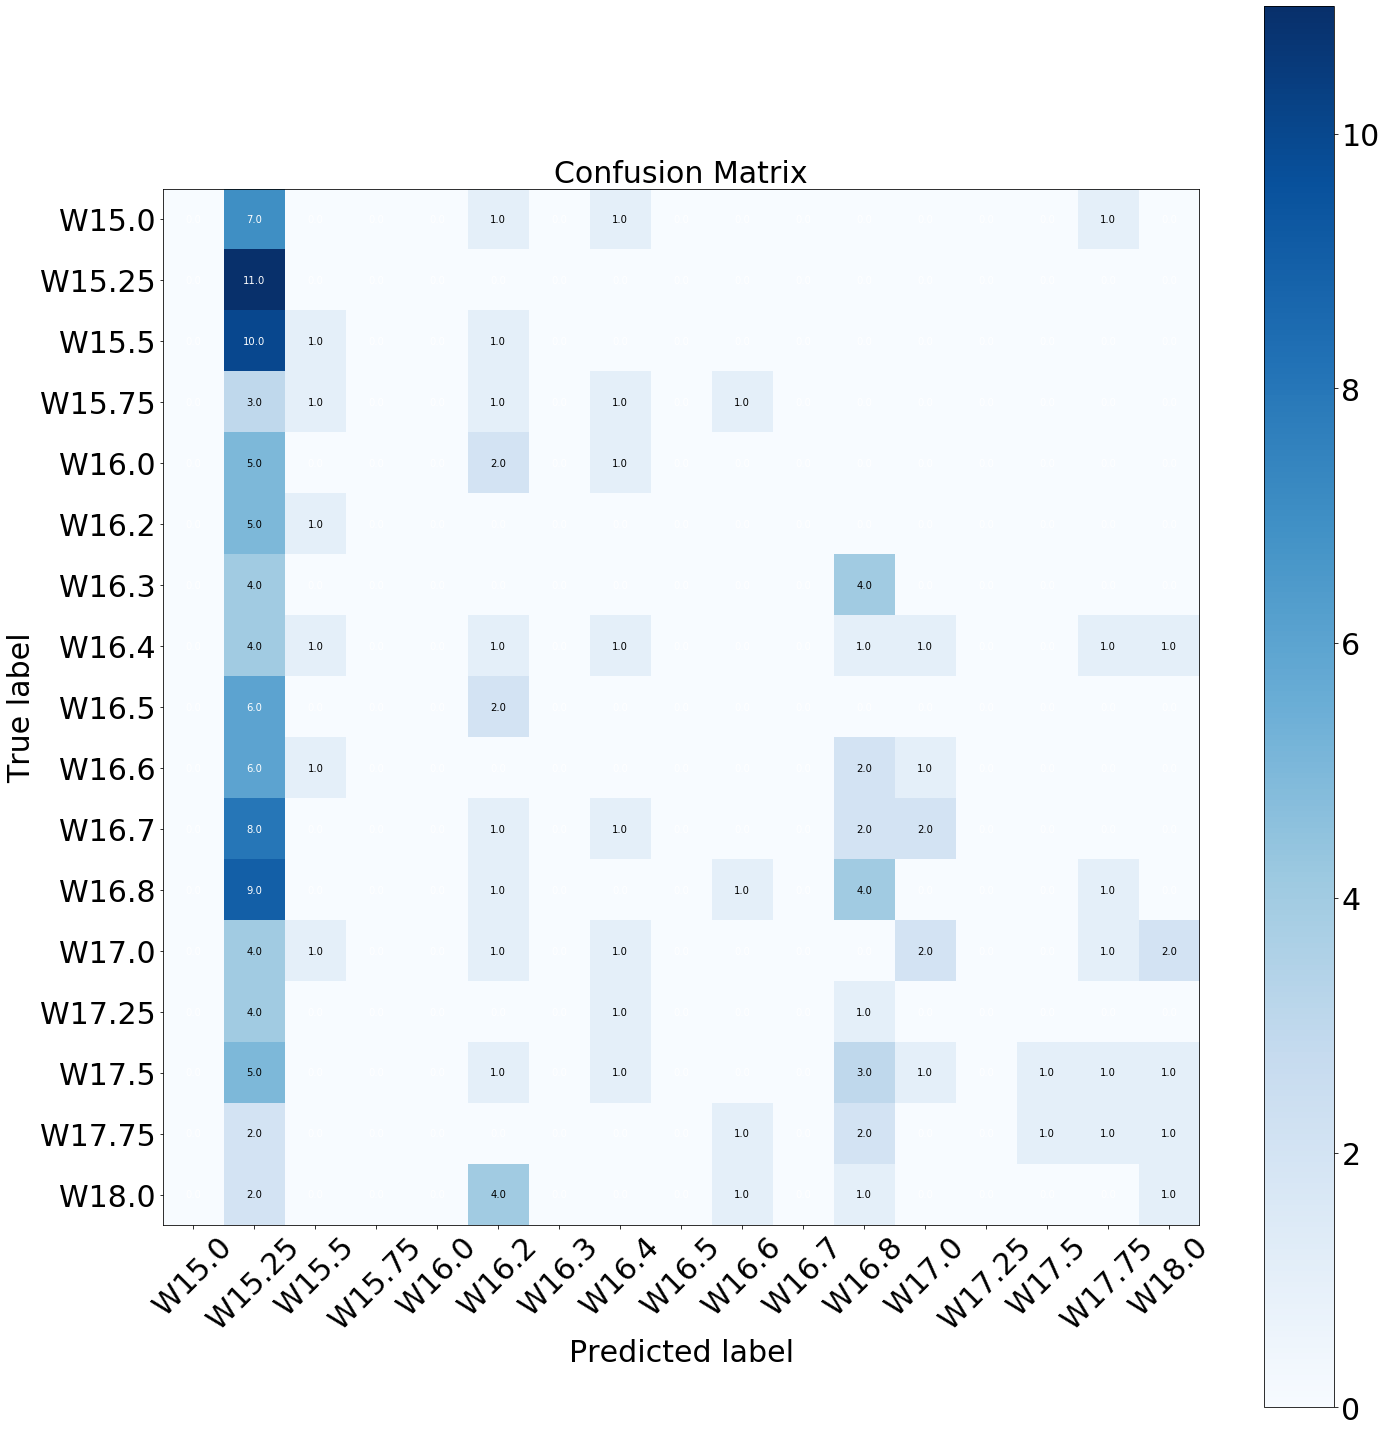

In [27]:
confusion_matrix_torch(cm,class_names)

## Hyperparameter tunning

In [28]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    global accuracy, _loss, val_accuracy, val_loss, epochs, val_epochs, epoch_acc
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracy=[]
    _loss=[]
    val_accuracy=[]
    val_loss=[]
    epochs=[]
    val_epochs=[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-' * 10)
        
    #two phases training and validating
        for phase in [train,val]:
            if phase == train:
                print('Training', end=" ")
                model.train() # set the model to training mode
            else:
                print('Validation', end=" ")
                model.eval() # set the model to evaluation mode
                
            batches= len(list(enumerate(phase)))
            print('with', batches, 'batches')
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            # print('--- iterating through data ...')
            
            for i, (inputs,labels,paths) in enumerate(phase):
                
                print(i*100//batches, '%', end="\r", flush=True)
                
                inputs=inputs.to(device)
                labels=labels.to(device)
                #paths=paths.to(device)
                                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()            
            
            if phase == train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss= {:4f}, accuracy= {:4f}'.format(
                    'Training result:', epoch_loss, epoch_acc))
                accuracy.append(epoch_acc)
                _loss.append(epoch_loss)
                epochs.append(epoch)
                
            if phase == val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss= {:4f}, val_accuracy= {:4f}'.format(
                    'Validation result:', epoch_loss, epoch_acc))
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)
                val_epochs.append(epoch)
                
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model        

In [29]:
def opt_lr_choice(learning_rate,model,criterion,num_epochs):
    #accuracy=np.zeros(len(optimizer))
    since=time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for lr in learning_rate:
        for k in range(4):
            optimizer=[torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0)
           , torch.optim.Adam(model.parameters(),lr=lr)
           , torch.optim.SGD(model.parameters(),lr=lr),  
           torch.optim.Adagrad(model.parameters(),lr=lr)]
            torch.manual_seed(myseed)
            criterion = nn.CrossEntropyLoss()
            opt=optimizer[k]
            print('lr', lr, 'optmizer',opt)
            if torch.cuda.is_available():
                model = model.cuda()
                criterion = criterion.cuda()


            exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
            train_model(model, criterion, opt,num_epochs,exp_lr_scheduler,batch_size=16)
        
            print('-------------------')
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return
        

In [30]:
lr=0.001
optimizer=[torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
           , torch.optim.Adam(model.parameters(),lr=lr)
           , torch.optim.SGD(model.parameters(),lr=lr),  
           torch.optim.Adagrad(model.parameters(),lr=lr)]
learning_rate=[0.1, 0.001, 0.0001,0.00001,0.000001,0.0000001]
criterion = nn.CrossEntropyLoss()


In [31]:
opt_lr_choice(learning_rate,model,criterion,1)

lr 0.1 optmizer Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.1
    rho: 0.9
    weight_decay: 0
)
Epoch 1/1
----------
Training with 1 batches
Training result: loss= 2.686663, accuracy= 0.176471
Validation with 1 batches
Validation result: val_loss= 8.211457, val_accuracy= 0.111765

Training complete in 0m 2s
Best val Acc: 0.111765
-------------------
lr 0.1 optmizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)
Epoch 1/1
----------
Training with 1 batches
Training result: loss= 2.668292, accuracy= 0.184314
Validation with 1 batches
Validation result: val_loss=  nan, val_accuracy= 0.070588

Training complete in 0m 2s
Best val Acc: 0.070588
-------------------
lr 0.1 optmizer SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch 1/1
----------
Training with 1 batches
Training result: loss= 34.068558, accuracy= 0.063399
Validation with 1 batches
V

Training with 1 batches
Training result: loss= 22.131058, accuracy= 0.058824
Validation with 1 batches
Validation result: val_loss= 5905.272461, val_accuracy= 0.076471

Training complete in 0m 2s
Best val Acc: 0.076471
-------------------
lr 1e-07 optmizer SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-07
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch 1/1
----------
Training with 1 batches
Training result: loss= 22.130850, accuracy= 0.058824
Validation with 1 batches
Validation result: val_loss= 3183.131348, val_accuracy= 0.088235

Training complete in 0m 2s
Best val Acc: 0.088235
-------------------
lr 1e-07 optmizer Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 1e-07
    lr_decay: 0
    weight_decay: 0
)
Epoch 1/1
----------
Training with 1 batches
Training result: loss= 22.130835, accuracy= 0.058824
Validation with 1 batches
Validation result: val_loss= 1738.262451, val_accuracy= 0.094118

Training complete in 0m 2s
Best va